In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES = 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import sys
import os
import blosc
import pickle

import numpy as np
import pandas as pd

from functools import partial
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from tensorflow.contrib.layers import xavier_initializer_conv2d
# from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset, F, V, B
from dataset import Batch, action, model, inbatch_parallel
from standard_models.resnet import ResNetModel
from task_03.my_batch import MnistBatch
from task_03.my_batch import draw_stats

In [44]:
np.random.seed(9)

In [45]:
loss_results = defaultdict(list)
test_loss_results = defaultdict(list)
acc_results = defaultdict(list)
test_acc_results = defaultdict(list)
ones_acc = defaultdict(list)
ones_loss = defaultdict(list)

In [46]:
src = 'C:/Users/Dari/Documents/az_training/task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())

In [47]:
full_labs = full_labs[:, :2]
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

data = pd.DataFrame(full_labs)

In [48]:
def split_indices(all_indices, proportion=10):
    train_len = int(len(all_indices) / 1.14 * proportion)
    train_idx = all_indices[:train_len]
    test_idx = all_indices[train_len:]
    return train_idx, test_idx

In [49]:
def create_dataset(data, proportion):
    indices_one = data[data[1] == 1.0].index.values
    indices_zero =  data[data[0] == 1.0].index.values
    train_idx, test_idx = split_indices(indices_one, proportion)
    print(len(test_idx), ' len test')
    print(len(train_idx), ' len train')

    train_idx = np.hstack((indices_zero, train_idx))
    trainset = Dataset(train_idx, MnistBatch)
    testset = Dataset(test_idx, MnistBatch)
    trainset.cv_split([0.8, 0.2])
    return trainset, testset

In [108]:
SIZE = 28
BATCH_SIZE = 100
NUM_ITERS = 500

In [60]:
def focal_loss(targets, predictions, gamma=0.5):
    print('gamma= %f' % gamma)
    probs = tf.nn.softmax(predictions)
    focal_factor = tf.pow((1 - probs), gamma)
    tuned_predictions = tf.exp(focal_factor) * predictions
    return tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=tuned_predictions)

In [61]:
config={'input': {'shape': [28, 28, 1], 'n_classes': 2, 'dim': 2},
        'length_factor': [3, 0, 0, 0],
        'layout': 'ca',
        'bottleneck':False,
        'max_pool': False,
        'loss': partial(focal_loss, gamma=1.),
        'conv_params': {'conv': {'kernel_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0), \
                                 'bias_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0)}},
        'optimizer': {'name':'Adam', 'use_locking': True}
       }

In [62]:
def test_focal_loss(trainset, testset, gammas, acc_results, loss_results, test_acc_results, test_loss_results, ones_acc, \
                    ones_loss, name=''):
    for index in range(len(gammas)):
        config['loss'] = partial(focal_loss, gamma=gammas[index])

        ppl = (trainset.train.p
                         .load(src=src, fmt='ndarray')
                         .init_variable('acc_history', init_on_each_run=list)
                         .init_variable('loss_history', init_on_each_run=list)
                         .init_model('dynamic', ResNetModel, 'MyResNet', config)
                         .train_model('MyResNet', fetches=['accuracy', 'loss'], feed_dict={'input_images': B('images'),
                                             'targets': B('labels')},
                                     save_to=[V('acc_history'), V('loss_history')],
                                     mode='a'))
        
        ppl_test = (trainset.test.p
                        .load(src=src, fmt='ndarray')
                        .init_variable('test_acc_history', init_on_each_run=list)
                        .init_variable('test_loss_history', init_on_each_run=list)
                        .import_model('MyResNet', ppl)
                        .predict_model('MyResNet', fetches=['accuracy', 'loss'], feed_dict={'input_images': B('images'),
                                                                                  'targets': B('labels')},
                                       save_to=[V('test_acc_history'), V('test_loss_history')],
                                       mode='a'))
        ppl_test_ones = (testset.p
                        .load(src=src, fmt='ndarray')
                        .init_variable('acc', init_on_each_run=list)
                        .init_variable('loss', init_on_each_run=list)
                        .import_model('MyResNet', ppl)
                        .predict_model('MyResNet', fetches=['accuracy', 'loss'], feed_dict={'input_images': B('images'),
                                                                                  'targets': B('labels')},
                                       save_to=[V('acc'), V('loss')],
                                       mode='a'))
        
        for i in tqdm(range(NUM_ITERS)):
            ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
            ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
            ppl_test_ones.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
        
        acc_results[name + '+' + str(index)] = ppl.get_variable('acc_history')
        loss_results[name + '+' + str(index)] = ppl.get_variable('loss_history')
        
        test_acc_results[name + '+' + str(index)] = ppl_test.get_variable('test_acc_history')
        test_loss_results[name + '+' + str(index)] = ppl_test.get_variable('test_loss_history')

        ones_acc[name + '+' + str(index)] = ppl_test_ones.get_variable('acc')
        ones_loss[name + '+' + str(index)] = ppl_test_ones.get_variable('loss')

In [109]:
trainset, testset = create_dataset(data, 0.1)
test_focal_loss(trainset, testset, [0.0, 0.5, 1.0, 2.0], acc_results, loss_results, test_acc_results, test_loss_results,\
                ones_acc, ones_loss, '0.1')

6673  len test
641  len train


gamma= 0.000000



gamma= 0.500000



gamma= 1.000000



gamma= 2.000000



In [113]:
begin = 0
end = 500

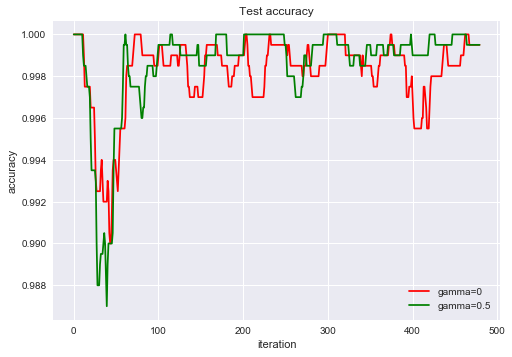

In [116]:
draw_stats([test_acc_results['0.1+2'][begin:end], \
            test_acc_results['0.1+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

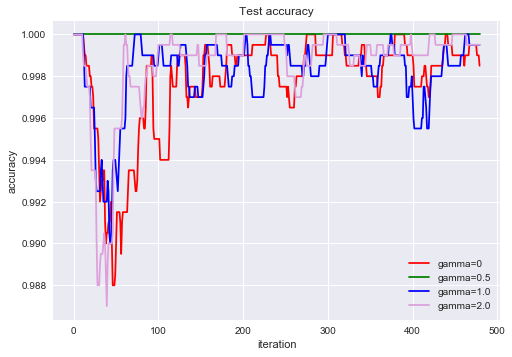

In [114]:
draw_stats([test_acc_results['0.1+0'][begin:end], test_acc_results['0.1+1'][begin:end], test_acc_results['0.1+2'][begin:end], \
            test_acc_results['0.1+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

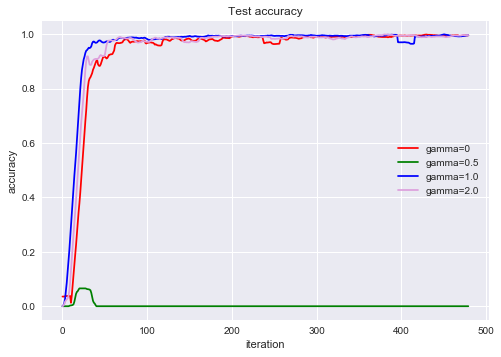

In [115]:
draw_stats([ones_acc['0.1+0'][begin:end], ones_acc['0.1+1'][begin:end], ones_acc['0.1+2'][begin:end], \
            ones_acc['0.1+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

### Test accuracy on well-balanced data

We can see that rather large factor gamma=2.0 works worse than others which are more or less the same including original cross entropy (factor=0.0)

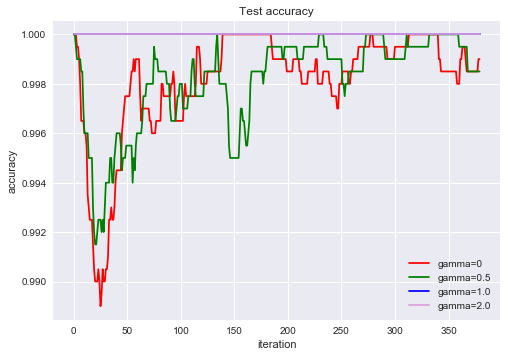

In [102]:
draw_stats([test_acc_results['0.1+0'][begin:end], test_acc_results['0.1+1'][begin:end], test_acc_results['0.1+2'][begin:end], \
            test_acc_results['0.1+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

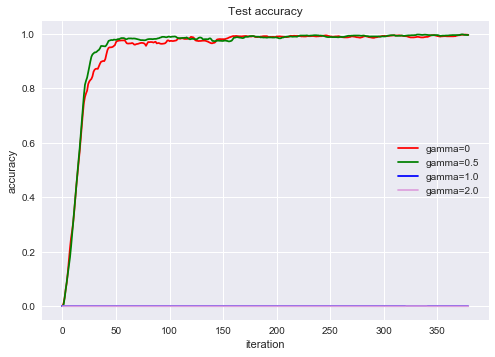

In [82]:
draw_stats([ones_acc['0.1+0'][begin:end], ones_acc['0.1+1'][begin:end], ones_acc['0.1+2'][begin:end], \
            ones_acc['0.1+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

In [75]:
trainset, testset = create_dataset(data, 0.05)
test_focal_loss(trainset, testset, [0.0, 0.5, 1.0, 2.0], acc_results, loss_results, test_acc_results, test_loss_results,\
                ones_acc, ones_loss, '0.05')

6994  len test
320  len train


gamma= 0.000000



gamma= 0.500000



gamma= 1.000000



gamma= 2.000000



In [88]:
name = '0.05'

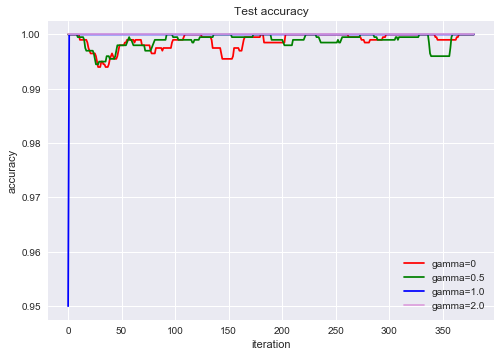

In [89]:
draw_stats([test_acc_results[name + '+0'][begin:end], test_acc_results[name + '+1'][begin:end], test_acc_results[name + '+2'][begin:end], \
            test_acc_results[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

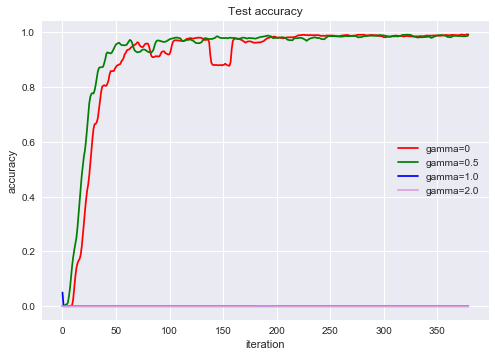

In [90]:
draw_stats([ones_acc[name + '+0'][begin:end], ones_acc[name + '+1'][begin:end], ones_acc[name + '+2'][begin:end], \
            ones_acc[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

In [95]:
trainset, testset = create_dataset(data, 0.01)
test_focal_loss(trainset, testset, [0.0, 0.5, 1.0, 2.0], acc_results, loss_results, test_acc_results, test_loss_results,\
                ones_acc, ones_loss, '0.01')

7250  len test
64  len train


gamma= 0.000000



gamma= 0.500000



gamma= 1.000000



gamma= 2.000000



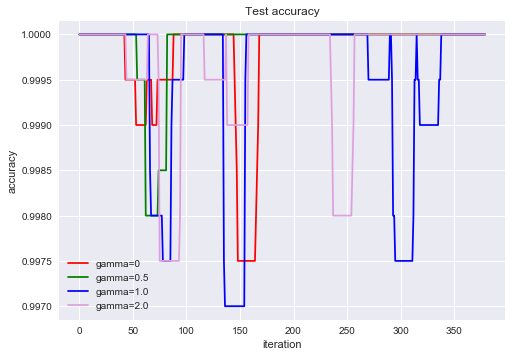

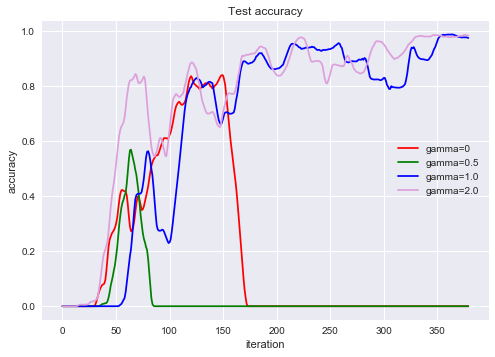

In [96]:
name = '0.01'
draw_stats([test_acc_results[name + '+00'][begin:end], test_acc_results[name + '+1'][begin:end], test_acc_results[name + '+2'][begin:end], \
            test_acc_results[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')
draw_stats([ones_acc[name + '+0'][begin:end], ones_acc[name + '+1'][begin:end], ones_acc[name + '+2'][begin:end], \
            ones_acc[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

In [98]:
trainset, testset = create_dataset(data, 0.005)
test_focal_loss(trainset, testset, [0.0, 0.5, 1.0, 2.0], acc_results, loss_results, test_acc_results, test_loss_results,\
                ones_acc, ones_loss, '0.005')

7282  len test
32  len train


gamma= 0.000000



gamma= 0.500000



gamma= 1.000000



gamma= 2.000000



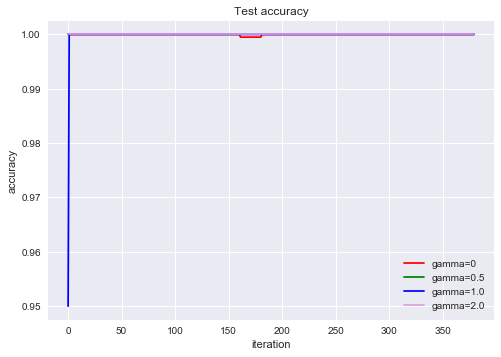

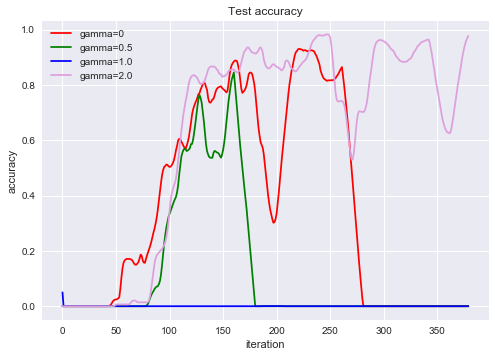

In [99]:
name = '0.005'
draw_stats([test_acc_results[name + '+0'][begin:end], test_acc_results[name + '+1'][begin:end], test_acc_results[name + '+2'][begin:end], \
            test_acc_results[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')
draw_stats([ones_acc[name + '+0'][begin:end], ones_acc[name + '+1'][begin:end], ones_acc[name + '+2'][begin:end], \
            ones_acc[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

7302  len test
12  len train


gamma= 0.000000



gamma= 0.500000



gamma= 1.000000



gamma= 2.000000



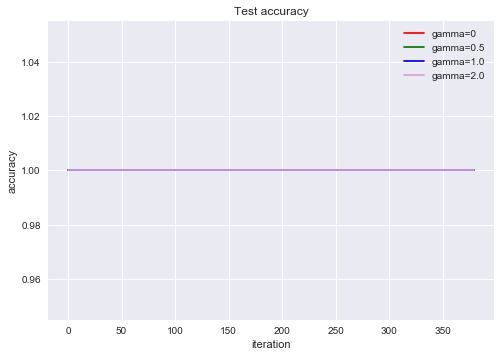

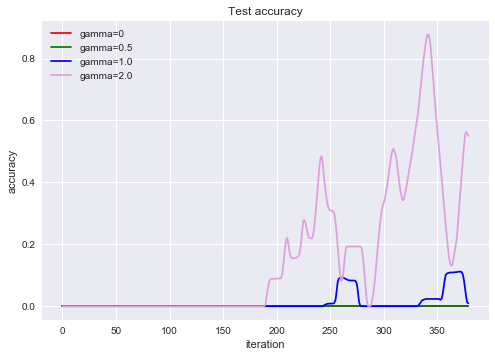

In [101]:
trainset, testset = create_dataset(data, 0.002)
test_focal_loss(trainset, testset, [0.0, 0.5, 1.0, 2.0], acc_results, loss_results, test_acc_results, test_loss_results,\
                ones_acc, ones_loss, '0.001')

draw_stats([ones_acc[name + '+0'][begin:end], ones_acc[name + '+1'][begin:end], ones_acc[name + '+2'][begin:end], \
            ones_acc[name + '+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

In [71]:
with open("test_loss_results.txt", "wb") as a:
    pickle.dump(test_loss_results, a)
    
with open("acc_results.txt", "wb") as a:
    pickle.dump(acc_results, a)

with open("test_acc_results.txt", "wb") as a:
    pickle.dump(test_acc_results, a)

### Let's train on unbalanced dataset with proporsion 1:10

In [53]:
unbalanced_train_idx = np.hstack((indices_zero, indices_one[:100]))

In [54]:
unbalanced_mnistset = Dataset(train_idx, MnistBatch)

In [55]:
unbalanced_mnistset.cv_split([0.7, 0.3])

In [56]:
test_focal_loss(unbalanced_mnistset, [0.0, 0.5, 1.0, 2.0], loss_results, test_loss_results, acc_results, test_acc_results, 
                name='unbalanced')

gamma= 0.000000



gamma= 0.500000



gamma= 1.000000



gamma= 2.000000



### Test accuracy on unbalanced data in proportion 1:10

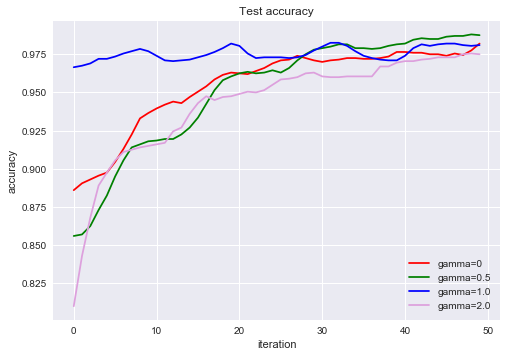

In [52]:
draw_stats([test_acc_results['unbalanced+0'][begin:end], test_acc_results['unbalanced+1'][begin:end], test_acc_results['unbalanced+2'][begin:end], \
            test_acc_results['unbalanced+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy')

### Test accuracy on unbalanced data in proportion 1:60

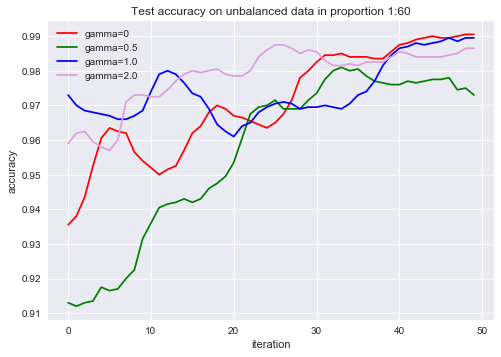

In [70]:
draw_stats([test_acc_results['unbalanced+0'][begin:end], test_acc_results['unbalanced+1'][begin:end], test_acc_results['unbalanced+2'][begin:end], \
            test_acc_results['unbalanced+3'][begin:end]], \
           ['gamma=0', 'gamma=0.5', 'gamma=1.0', 'gamma=2.0'], 'Test accuracy on unbalanced data in proportion 1:60')

Now we see that the more unbalanced is data, the better works the weighted loss with larger factor.

In [72]:
test_focal_loss(unbalanced_mnistset, [3.0, 5.0], loss_results, test_loss_results, acc_results, test_acc_results, 
                name='unbalanced_larger_factor')

gamma= 3.000000



gamma= 5.000000



In [91]:
begin = 50
end = 150

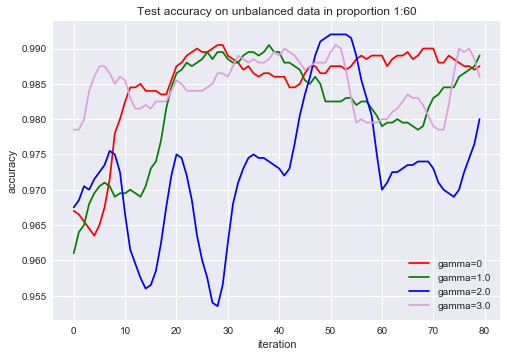

In [92]:
draw_stats([test_acc_results['unbalanced+0'][begin:end], test_acc_results['unbalanced+2'][begin:end], \
            test_acc_results['unbalanced_larger_factor+0'][begin:end], test_acc_results['unbalanced+3'][begin:end]], \
           ['gamma=0', 'gamma=1.0', 'gamma=2.0', 'gamma=3.0', 'gamma=5.0'], 'Test accuracy on unbalanced data in proportion 1:60')